### Download data

In [ ]:
# Download zip file at https://www.kaggle.com/puneet6060/intel-image-classification
# then save to ./Data

In [ ]:
import os
import zipfile

In [2]:
local_zip = './Data/archive.zip'
base_dir = './Data/intel-images'

In [ ]:
zip_file = zipfile.ZipFile(local_zip, 'r')
zip_file.extractall(base_dir)
zip_file.close()

In [3]:
train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir  = os.path.join(base_dir, 'seg_test/seg_test')

buildings_dir = os.path.join(train_dir, 'buildings')
forest_dir    = os.path.join(train_dir, 'forest')
glacier_dir   = os.path.join(train_dir, 'glacier')
mountain_dir  = os.path.join(train_dir, 'mountain')
sea_dir       = os.path.join(train_dir, 'sea')
street_dir    = os.path.join(train_dir, 'street')

buildings_fnames = os.listdir(buildings_dir)
forest_fnames    = os.listdir(forest_dir)
glacier_fnames   = os.listdir(glacier_dir)
mountain_fnames  = os.listdir(mountain_dir)
sea_fnames       = os.listdir(sea_dir)
street_fnames    = os.listdir(street_dir)

In [4]:
print('Total building training images:', len(buildings_fnames))
print('Total forest training images:',   len(forest_fnames))
print('Total glacier training images:',  len(glacier_fnames))
print('Total mountain training images:', len(mountain_fnames))
print('Total sea training images:',      len(sea_fnames))
print('Total street training images:',   len(street_fnames))

print('Total training images:', len(buildings_fnames)+len(forest_fnames)+len(glacier_fnames)+len(mountain_fnames)\
                                +len(sea_fnames)+len(street_fnames))

Total building training images: 2191
Total forest training images: 2271
Total glacier training images: 2404
Total mountain training images: 2512
Total sea training images: 2274
Total street training images: 2382
Total training images: 14034


### Visualize data

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows, ncols = 4, 4
pic_index = 0

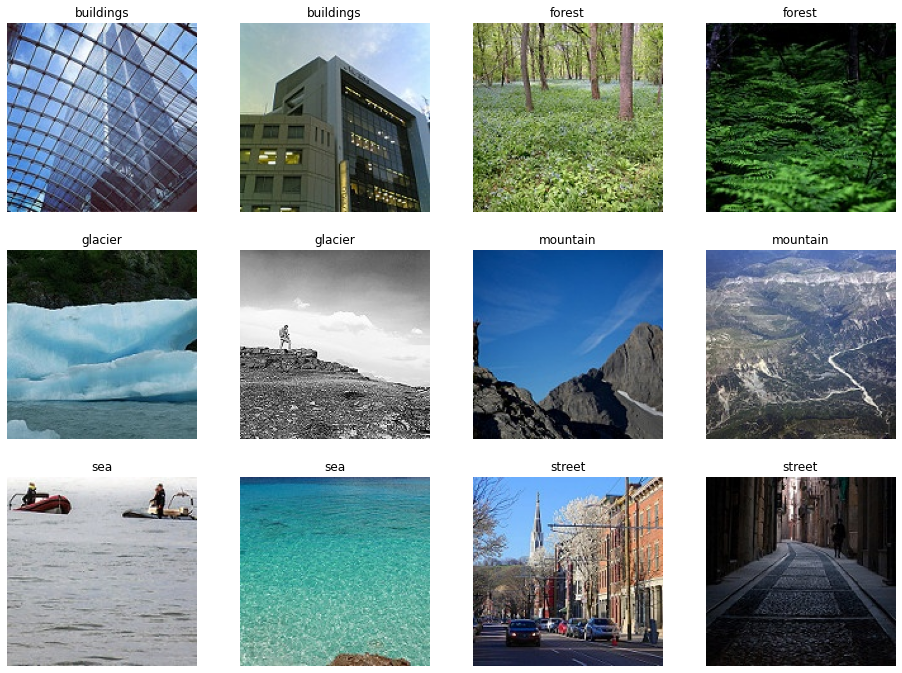

In [26]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 2

next_building_pic = [os.path.join(buildings_dir, fname) for fname in buildings_fnames[pic_index-2:pic_index]]
next_forest_pic   = [os.path.join(forest_dir, fname) for fname in forest_fnames[pic_index-2:pic_index]]
next_glacier_pic  = [os.path.join(glacier_dir, fname) for fname in glacier_fnames[pic_index-2:pic_index]]
next_mountain_pic = [os.path.join(mountain_dir, fname) for fname in mountain_fnames[pic_index-2:pic_index]]
next_sea_pic      = [os.path.join(sea_dir, fname) for fname in sea_fnames[pic_index-2:pic_index]]
next_street_pic   = [os.path.join(street_dir, fname) for fname in street_fnames[pic_index-2:pic_index]]

next_img = next_building_pic + next_forest_pic + next_glacier_pic + next_mountain_pic + next_sea_pic + next_street_pic

from pathlib import Path
for i, img_path in enumerate(next_img):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis('Off')
    
    path = Path(img_path)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(str(path.parent)[38:])
plt.show()

### Preprocess data

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

In [34]:
train_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
    )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150,150),
        class_mode='categorical',
        batch_size=125,
        subset='training'
    )

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150,150),
        class_mode='categorical',
        batch_size=125,
        subset='validation'
    )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150,150),
        class_mode='categorical',
        batch_size=125
    )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Define callback function

In [35]:
class Callback_(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.99:
            print('Reached 99% accuracy. Stopping training.')
            self.model.stop_training = True

### Define model

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

In [41]:
callbacks = Callback_()

In [52]:
STEPS_PER_EPOCH = 11230//125
VALIDATION_STEPS = 2804//125

### Train model

In [53]:
history = model.fit(
        train_generator,
        epochs=20,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        verbose=1,
        callbacks=[callbacks]
    )

Epoch 1/20
89/89 [==============================] - 313s 4s/step - loss: 0.7975 - accuracy: 0.6983 - val_loss: 0.7291 - val_accuracy: 0.7342
Epoch 2/20
89/89 [==============================] - 446s 5s/step - loss: 0.6316 - accuracy: 0.7687 - val_loss: 0.6291 - val_accuracy: 0.7793
Epoch 3/20
89/89 [==============================] - 415s 5s/step - loss: 0.4870 - accuracy: 0.8209 - val_loss: 0.7463 - val_accuracy: 0.7418
Epoch 4/20
89/89 [==============================] - 392s 4s/step - loss: 0.3466 - accuracy: 0.8705 - val_loss: 0.7142 - val_accuracy: 0.7796
Epoch 5/20
89/89 [==============================] - 381s 4s/step - loss: 0.2436 - accuracy: 0.9154 - val_loss: 0.8178 - val_accuracy: 0.7844
Epoch 6/20
89/89 [==============================] - 387s 4s/step - loss: 0.1863 - accuracy: 0.9389 - val_loss: 0.9028 - val_accuracy: 0.7865
Epoch 7/20
89/89 [==============================] - 387s 4s/step - loss: 0.1573 - accuracy: 0.9551 - val_loss: 1.8755 - val_accuracy: 0.6836
Epoch 8/20
89

In [55]:
model.save('simple_model.h5')

In [2]:
model = tf.keras.models.load_model('simple_model.h5')

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

### Plot accuracy and loss

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim([0,1])
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0,1])
plt.show()

### Test model with unseen data from seg_pred

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from ipywidgets import FileUpload

In [ ]:
uploader = FileUpload(multiple=True)
uploader

In [ ]:
for name, file_info in uploader.value.items():
    path = './Data/intel-images/seg_pred/seg_pred/' + name
    img = image.load_img(path, target_size=(150,150))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    classes = model.predict(images, batch_size=10)
    
    index = np.argmax(classes[0])
        
    if index == 0:
        print("{} is a building".format(name))
    elif index == 1:
        print("{} is a forest".format(name))
    elif index == 2:
        print("{} is a glacier".format(name))
    elif index == 3:
        print("{} is a moutain".format(name))
    elif index == 4:
        print("{} is a sea".format(name))
    else:
        print("{} is a street".format(name))
    